# ЛР6: Прогнозирование временных рядов.

Выполнил: **Баранов Владимир Георгиевич, ШАД-311**

In [1]:
import os
import pandas as pd
import numpy as np
import requests

from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)  # нужно 1.9.0 или выше
init_notebook_mode(connected=True)

def plotly_df(df, title=""):
    data = []
    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

5.22.0


In [5]:
df = pd.read_csv('/Users/vladimirbaranov/Downloads/wiki_machine_learning.csv', sep = " ")
df = df[df["count"] != 0].copy()
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [6]:
df.shape

(383, 7)

In [7]:
df["date"] = pd.to_datetime(df["date"])
df.dtypes

date     datetime64[ns]
count             int64
lang             object
page             object
rank              int64
month             int64
title            object
dtype: object

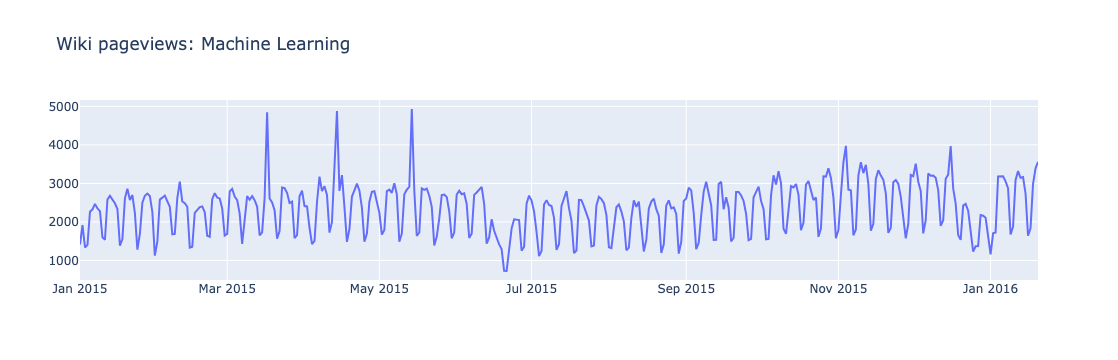

In [8]:
plotly_df(df.set_index("date")[["count"]], title="Wiki pageviews: Machine Learning")

In [9]:
# В разных окружениях пакет может называться fbprophet или prophet
try:
    from fbprophet import Prophet
except Exception:
    try:
        from prophet import Prophet
    except Exception:
        # если нет — попробуем установить (в Colab/локально обычно работает)
        import sys
        !{sys.executable} -m pip install --quiet prophet
        from prophet import Prophet

In [10]:
predictions = 30

df_prophet = df[["date", "count"]].copy()
df_prophet.columns = ["ds", "y"]

train_df = df_prophet.iloc[:-predictions].copy()
test_df  = df_prophet.iloc[-predictions:].copy()

train_df.tail(), test_df.head()

(            ds     y
 358 2015-12-17  2870
 363 2015-12-18  2475
 364 2015-12-19  1659
 344 2015-12-20  1534
 343 2015-12-21  2425,
             ds     y
 346 2015-12-22  2469
 345 2015-12-23  2292
 348 2015-12-24  1671
 347 2015-12-25  1227
 350 2015-12-26  1367)

In [11]:
m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)

m.fit(train_df)

future = m.make_future_dataframe(periods=predictions, freq="D", include_history=True)
forecast = m.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

02:15:09 - cmdstanpy - INFO - Chain [1] start processing
02:15:10 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
378,2016-01-16,2345.439265,1981.635867,2726.380057
379,2016-01-17,2506.846352,2146.473806,2875.049830
380,2016-01-18,3528.137686,3169.475212,3890.396127
381,2016-01-19,3799.113732,3426.224282,4178.474863
382,2016-01-20,3696.285494,3324.887016,4045.426361


In [12]:
target_date = pd.Timestamp("2016-01-20")

pred_20jan = forecast.loc[forecast["ds"] == target_date, "yhat"]
if pred_20jan.empty:
    raise ValueError("В forecast нет даты 2016-01-20. Проверь диапазон дат в данных.")
pred_20jan_value = float(pred_20jan.iloc[0])

print("Вопрос 1. Прогноз на 2016-01-20 (округлено):", int(round(pred_20jan_value)))

Вопрос 1. Прогноз на 2016-01-20 (округлено): 3696


In [13]:
# Склеиваем факт и прогноз по датам тестового окна
fc_test = forecast[["ds", "yhat"]].merge(test_df, on="ds", how="inner")

y_true = fc_test["y"].astype(float).values
y_pred = fc_test["yhat"].astype(float).values

mae = np.mean(np.abs(y_true - y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # в %

print("Вопрос 2. MAPE (%):", round(float(mape), 6))
print("Вопрос 3. MAE:", round(float(mae), 6))

Вопрос 2. MAPE (%): 33.57448
Вопрос 3. MAE: 606.107952


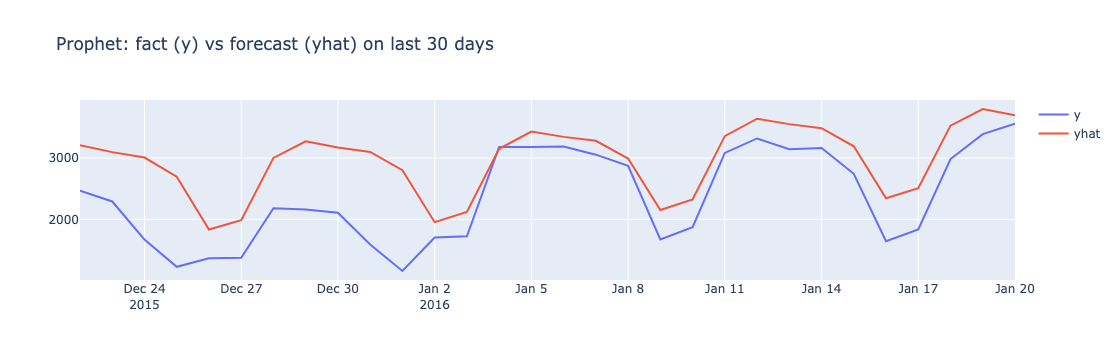

In [14]:
viz = fc_test.copy()
viz = viz.set_index("ds")[["y", "yhat"]]
plotly_df(viz, title="Prophet: fact (y) vs forecast (yhat) on last 30 days")

## Предсказываем с помощью ARIMA / SARIMAX

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [16]:
ts = df.set_index("date")["count"].asfreq("D")

adf_stat, p_value, lags, nobs, crit_vals, icbest = adfuller(ts.dropna(), autolag="AIC")

is_stationary = p_value < 0.05

print("ADF statistic:", adf_stat)
print("p-value:", p_value)
print("Лаги:", lags, "| наблюдений:", nobs)
print("Критические значения:", crit_vals)
print("Вопрос 4. Ряд стационарен?" , "ДА" if is_stationary else "НЕТ")

ADF statistic: -3.2888636389431065
p-value: 0.01538366841946938
Лаги: 15 | наблюдений: 367
Критические значения: {'1%': -3.448294490928673, '5%': -2.869447722240253, '10%': -2.570982681065269}
Вопрос 4. Ряд стационарен? ДА


In [ ]:
import itertools
import warnings
warnings.filterwarnings("ignore")

y = ts.copy()

# Небольшая, но адекватная сетка (обычно ее достаточно для учебной лабы)
p = q = range(0, 3)   # 0,1,2
d = range(0, 2)       # 0,1
pdq = list(itertools.product(p, d, q))

P = Q = range(0, 2)   # 0,1
D = range(0, 2)       # 0,1
s = 7                 # недельная сезонность
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

best_aic = np.inf
best_order = None
best_seasonal_order = None

for order in pdq:
    for sorder in seasonal_pdq:
        try:
            model = SARIMAX(
                y,
                order=order,
                seasonal_order=sorder,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False, maxiter=50)

            if res.aic < best_aic:
                best_aic = res.aic
                best_order = order
                best_seasonal_order = sorder
        except Exception:
            continue

print("Вопрос 5. Лучшая модель по AIC:")
print("order =", best_order)
print("seasonal_order =", best_seasonal_order)
print("AIC =", best_aic)